In [1]:
import numpy as np
import pandas as pd

In [2]:
from collections import defaultdict

In [3]:
import pickle

In [4]:
import seaborn as sns

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score

In [8]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

In [ ]:
#histone cell sp features:
#/data/data_repo/shengchd/rf_training/cell_sp_features_query/histone_mark_cell_sp_features/

# Function to reorder alleles for each SNP in order of ref,alt, so can be merged with ChIP signal & funsig dataframe

In [9]:
def reorder_alleles(chrom,pos,allele1,allele2):
    '''Function to reorder two alleles in order of ref, alt
    Args:
        chrom (str): query chromosome (e.g. chr1)
        pos (int): query position (0-based)
        allele1 (str): base of 1st allele (A/C/G/T)
        allele2 (str): base of 2nd allele (A/C/G/T)
    Returns:
        alleles (tuple): two alleles in order of ref, alt
    '''
    from pyfaidx import Fasta
    ref = Fasta('/data/genomes/hg19/seq/hg19.fa',rebuild=False)
    
    ref_allele = ref[chrom][pos].seq.upper()
    if (ref_allele == allele1):
        alleles = (allele1,allele2)
    elif (ref_allele == allele2):
        alleles = (allele2,allele1)
    else:
        print (chrom + " " + str(pos)+ " no match")
        alleles = (allele1,allele2)
    return alleles

# Read generic features

In [12]:
train_ASB = pd.read_csv('train_ASB_FINAL.txt',sep='\t')

In [13]:
train_ASB.head()

,chrom,end,ref,alt,label,CHIP,DNASE,PWM,FOOTPRINT,EQTL_2,PWM_matched,FOOTPRINT_matched,IC_change,IC_matched_change,funsig,ChIP_var,ChIP_max,ChIP_quantile1,ChIP_quantile2,ChIP_quantile3
0,chr10,10107267,A,G,1,0,0,1,0,0,0,0,1.99,0.0,0.022459,0.0590,1.86,0.1466,0.2203,0.4275
1,chr10,101365302,G,A,1,1,1,0,0,0,0,0,0.00,0.0,0.158940,17.3444,65.24,0.1375,0.2330,0.4826
2,chr10,101844785,A,G,1,1,1,0,0,0,0,0,0.00,0.0,0.004548,47.4364,115.26,0.1359,0.3016,0.7071
3,chr10,102027407,C,T,1,1,1,1,1,0,0,0,0.00,0.0,0.001705,732.4732,267.98,0.4851,2.1454,8.0536
4,chr10,102084897,C,T,1,1,1,0,0,0,0,0,0.00,0.0,0.191050,1.7908,20.92,0.0968,0.1992,0.3796


In [14]:
train_ASB.shape

(14878, 20)

# Read cell sp features

In [15]:
cells = ['GM12878','A549','H1hESC','HepG2','K562','MCF7']

In [16]:
df_all_dict = dict()

In [18]:
path = '/data/data_repo/shengchd/regulomedb_new_query/ASB_cell_specific_query/'

In [22]:
for cell in cells:
    ASB_genotypes = pd.read_csv(path + cell + '.bed',sep='\t',header = None)
    ASB_genotypes.columns = ['chrom','start','end','ref','alt']
    #reorder to ref, alt
    ASB_genotypes[['ref','alt']] = [reorder_alleles(chrom,pos,allele1,allele2) for  chrom,pos,allele1,allele2 in zip(ASB_genotypes['chrom'],ASB_genotypes['start'],ASB_genotypes['ref'],ASB_genotypes['alt'])]        
    ASB_genotypes['cellSp_label'] = 1
    df = pd.merge(train_ASB,ASB_genotypes,how='left')
    df['cellSp_label'] = df['cellSp_label'].fillna(0)
    df['cellSp_label'] = df['cellSp_label'].astype('int64') #if ASB in cell
    print (cell,sum(df['cellSp_label']))
    df_cellSp = pd.read_csv(path + 'train_ASB_control_added_' + cell + '_cell_sp_features.txt',sep="\t")
    df_cellSp = df_cellSp.drop_duplicates()
    df_cellSp_hist = pd.read_csv(path + 'histone_marks/train_ASB_control_added_' + cell + '_cell_sp_hist_features.txt',sep='\t')
    df_cellSp_hist = df_cellSp_hist.drop_duplicates()
    df_all = pd.merge(df,df_cellSp)
    df_all = pd.merge(df_all,df_cellSp_hist)
    df_all_dict[cell] = df_all

GM12878 1844
A549 215
H1hESC 1460
HepG2 2637
K562 761
MCF7 645


## Output FINAL cell sp features (dict of dataframe)

In [25]:
pickle.dump(df_all_dict,open('df_cell_sp_all_FINAL.pkl','wb'))

In [307]:
df_all.columns

Index(['chrom', 'end', 'ref', 'alt', 'label', 'CHIP', 'DNASE', 'PWM',
       'FOOTPRINT', 'EQTL_2', 'PWM_matched', 'FOOTPRINT_matched', 'IC_change',
       'IC_matched_change', 'funsig', 'ChIP_var', 'ChIP_max', 'ChIP_quantile1',
       'ChIP_quantile2', 'ChIP_quantile3', 'start', 'cellSp_label',
       'CHIP_cellSp', 'DNASE_cellSp', 'FOOTPRINT_cellSp', 'EQTL_2_cellSp',
       'PWM_matched_cellSp', 'FOOTPRINT_matched_cellSp', 'IC_matched_cellSp',
       'H2AFZ_cellSp', 'H2AK5ac_cellSp', 'H2AK9ac_cellSp', 'H2BK120ac_cellSp',
       'H2BK12ac_cellSp', 'H2BK15ac_cellSp', 'H2BK20ac_cellSp',
       'H2BK5ac_cellSp', 'H3F3A_cellSp', 'H3K14ac_cellSp', 'H3K18ac_cellSp',
       'H3K23ac_cellSp', 'H3K23me2_cellSp', 'H3K27ac_cellSp',
       'H3K27me3_cellSp', 'H3K36me3_cellSp', 'H3K4ac_cellSp', 'H3K4me1_cellSp',
       'H3K4me2_cellSp', 'H3K4me3_cellSp', 'H3K56ac_cellSp', 'H3K79me1_cellSp',
       'H3K79me2_cellSp', 'H3K9ac_cellSp', 'H3K9me1_cellSp', 'H3K9me2_cellSp',
       'H3K9me3_cellSp', 'H3T

In [309]:
for cell in df_all_dict.keys():
    df_all = df_all_dict[cell]
    df_all[['chrom','end','ref','alt','cellSp_label'] + features_names_cell_sp].to_csv('train_ASB_cellSp_features_' + cell + '.txt',sep='\t',index=False)

# Read generic rf

In [30]:
filename = 'ASB_rf_IC_change_add_control.sav'
clf_generic = pickle.load(open(filename,'rb'))

In [31]:
#generic features
features = ['CHIP','DNASE','PWM','FOOTPRINT','EQTL_2','PWM_matched','FOOTPRINT_matched','IC_change','IC_matched_change','funsig','ChIP_var','ChIP_max','ChIP_quantile1','ChIP_quantile2','ChIP_quantile3']

In [292]:
df_all = df_all_dict['A549'] #use one union set as representative

In [33]:
y_scores = clf_generic.predict_proba(df_all[features])[:,1] #generic scores, same order for all cells

# cellSp rf = generic * cellSp features

In [306]:
#removed H3K9me3
features_names_cell_sp = ['H2AFZ_cellSp',
 'H3K27ac_cellSp',
 'H3K27me3_cellSp',
 'H3K36me3_cellSp',
 'H3K4me1_cellSp',
 'H3K4me2_cellSp',
 'H3K4me3_cellSp',
 'H3K79me2_cellSp',
 'H3K9ac_cellSp',
 'H4K20me1_cellSp',
 'DNASE_cellSp',
 'FOOTPRINT_cellSp']

In [37]:
clf_cellSp=RandomForestClassifier(class_weight='balanced',n_estimators=100,random_state=100,oob_score=True)

In [38]:
fold = 5
cv = StratifiedKFold(n_splits=fold,shuffle=True,random_state=42)

In [ ]:
roc_aucs = defaultdict(list)
ave_prs = defaultdict(list)
cors = defaultdict(list)
for cell in cells:
    print (cell)
    df_all = df_all_dict[cell]
    x = np.array(df_all[features_names_cell_sp])
    y = df_all['cellSp_label']
    for train, test in cv.split(x,y):
        y_1 = y_scores[test] #generic score from generic clf
        y_2 = clf_cellSp.fit(x[train], y[train]).predict_proba(x[test])[:,1]
        y_true = y[test]
        roc_aucs['generic'].append(roc_auc_score(y_true, y_1))
        roc_aucs['cellsp_only'].append(roc_auc_score(y_true, y_2))
        roc_aucs['cellsp'].append(roc_auc_score(y_true, y_1 * y_2))
        ave_prs['generic'].append(average_precision_score(y_true, y_1))
        ave_prs['cellsp_only'].append(average_precision_score(y_true, y_2))
        ave_prs['cellsp'].append(average_precision_score(y_true, y_1 * y_2))
        cors['generic'].append(np.corrcoef(y_1,y_true)[0,1])
        cors['cellsp_only'].append(np.corrcoef(y_2,y_true)[0,1])
        cors['cellsp'].append(np.corrcoef(y_1 * y_2,y_true)[0,1])
    print ('AUPR')
    for model in ave_prs.keys():
        print (model,np.round(np.mean(np.array(ave_prs[model])),3))
    print ('ROCAUC')
    for model in roc_aucs.keys():
        print (model,np.round(np.mean(np.array(roc_aucs[model])),3))
    print ('COR')
    for model in cors.keys():
        print (model,np.round(np.mean(np.array(cors[model])),3))
        #importance = clf_cellSp.feature_importances_
        #features_imp = {'feature':features_names_cell_sp,'importance':list(importance)}
        #print(pd.DataFrame(features_imp).sort_values(by=['importance'],ascending=False))

# Ensemble model

In [75]:
clf = {}

In [76]:
features_names_cell_sp_2

['H3K27ac_cellSp',
 'H3K36me3_cellSp',
 'H3K4me1_cellSp',
 'H3K4me3_cellSp',
 'H3K27me3_cellSp',
 'DNASE_cellSp',
 'FOOTPRINT_cellSp']

In [77]:
#adjusted class weight
for cell in cells:
    df_all = df_all_dict[cell]
    x = np.array(df_all[features_names_cell_sp_2])
    y = df_all['cellSp_label']
    clf[cell]=RandomForestClassifier(class_weight='balanced',n_estimators=100,random_state=100,oob_score=True)
    clf[cell].fit(x,y)  

In [78]:
#oob
for cell in cells:
    print (cell,clf[cell].oob_score_)

GM12878 0.7613254469686785
A549 0.7743648339830622
H1hESC 0.7700631805350181
HepG2 0.6683694044898508
K562 0.6886678316978089
MCF7 0.7002957386745531


In [291]:
pickle.dump(clf,open('ASB_cell_sp_clf_dict.pkl','wb')) #output cellSp_ensemble in 6 ASB cells

## Violin plot on ASB set

In [90]:
#cell sp final scores; 7 features
x_preds_final = defaultdict(list)

for i in cells: #features from i
    for cell in cells: #ASB from cell
        df_ASB = df_all_dict[i].loc[df_all_dict[cell]['cellSp_label']==1]
        y_ASB_generic = y_scores[df_all_dict[cell]['cellSp_label']==1]
        x_ASB = df_ASB[features_names_cell_sp_2]
        y_ASB = np.mean(np.array([list(clf[c].predict_proba(x_ASB)[:,1]) for c in cells]),axis=0)
        x_preds_final[cell].append(list(y_ASB*y_ASB_generic))

Text(0, 0.5, 'ASB cell type')

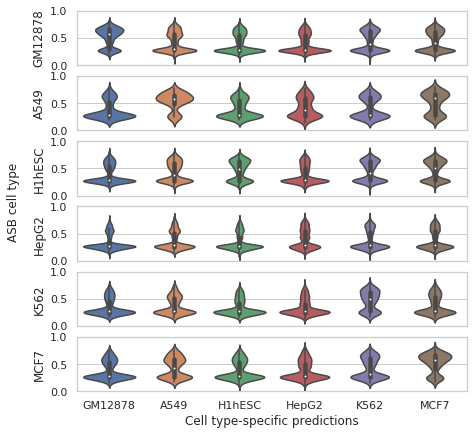

In [152]:
#plot boxplot/violin plot; final scores
fig, axes = plt.subplots(6, 1,sharex=True, sharey=True,figsize=(7,7))
plt.subplots_adjust(hspace = .2)

for i in range(6):
    x_preds_df = pd.DataFrame(np.array(x_preds_final[cells[i]]).transpose(),columns=cells)
    x_preds_df = x_preds_df.melt()
    x_preds_df.columns = ['cell','prediction scores']
    sns.violinplot(x='cell',y='prediction scores',data=x_preds_df,ax=axes[i])
    axes[i].set_ylabel(cells[i])
    axes[i].set_xlabel('')
    axes[i].set_ylim(0,1)
axes[5].set_xlabel('Cell type-specific predictions')
fig.text(0,0.5,'ASB cell type', va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])
#fig.tight_layout()